## MECE For the whole Group

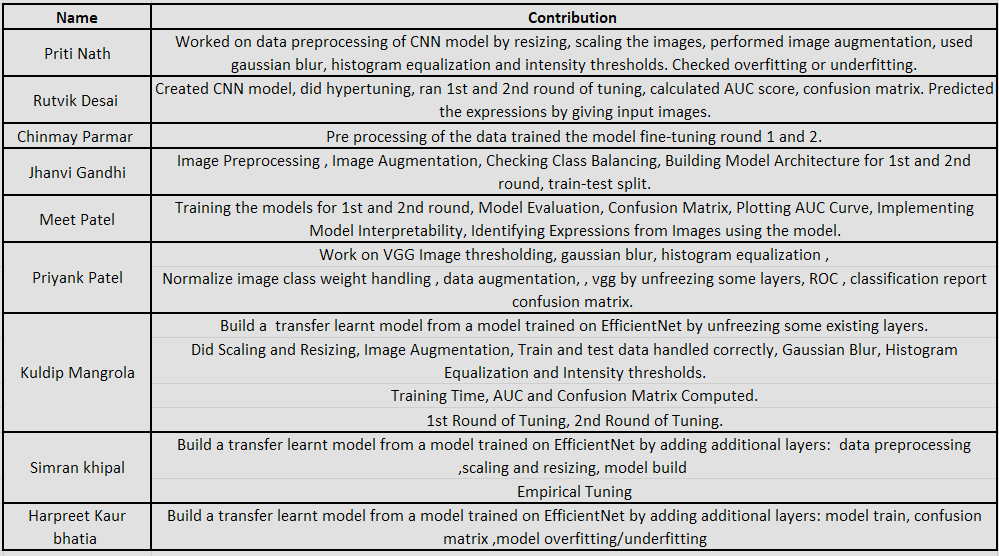

## Task Status For this file

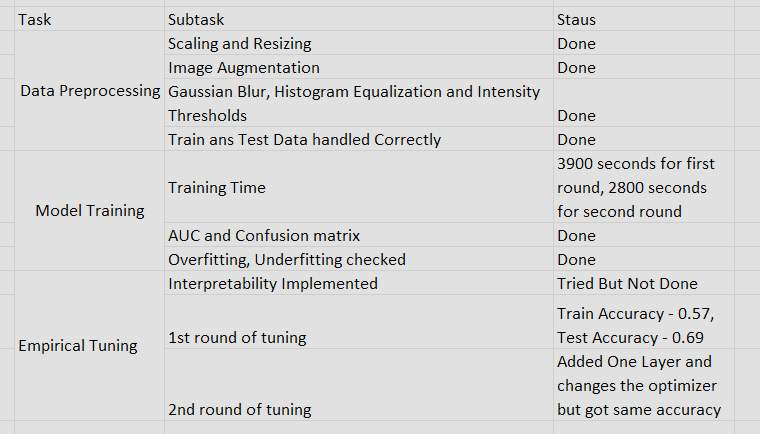

In [ ]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc
from skimage import filters, exposure
import cv2
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from keras.regularizers import l2
import random
import math
import warnings

warnings.filterwarnings('ignore')

## Data Preparation

In [ ]:
data_dir = "dataset/"
expression_labels = os.listdir(data_dir)
num_classes = len(expression_labels)

### Image Preprocessing
- As Mentioned in the instructions we tried the image preprocessing steps like Applying Gaussian Blur, Histogram Equalozation, and Intensity Thresholds.
- However, Applying those steps always resulted in a lower accuracy of models, so we didn't use the preprocessing function at last attempt.

In [ ]:
def preprocess_image(image):

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_blurred = cv2.GaussianBlur(image_rgb, (5, 5), 0)
    image_gray = cv2.cvtColor(image_blurred, cv2.COLOR_RGB2GRAY)
    image_equalized = cv2.equalizeHist(image_gray)
    _, image_thresholded = cv2.threshold(image_equalized, 127, 255, cv2.THRESH_BINARY)
    image_thresholded_rgb = cv2.cvtColor(image_thresholded, cv2.COLOR_GRAY2RGB)
    image_resized = cv2.resize(image_thresholded_rgb, (224, 224))

    return image_resized

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

### Checking the class balancing

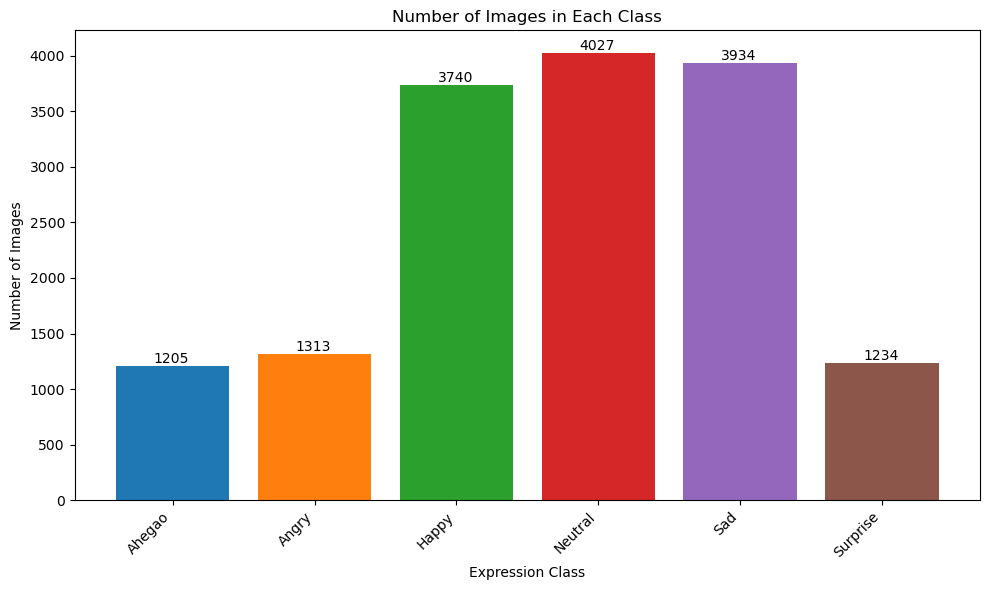

In [ ]:
class_counts = {}

for label_id, label in enumerate(expression_labels):
    images = os.listdir(os.path.join(data_dir, label))
    num_images = len(images)
    class_counts[label] = num_images

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=plt.cm.tab10(np.arange(len(class_counts))))
plt.title('Number of Images in Each Class')
plt.xlabel('Expression Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/3, yval, int(yval), va='bottom')

plt.tight_layout()
plt.show()

### As we saw, the number of images in a class is highly uneven. So, we've selected a different approach to tackle this.
- We will use 1100 images from all subdirectories in the train dataset, and 100 images from all subdirectories in the test dataset.
- Doing this, we can ensure that the class seperability in the train ans test sets is balanced

In [ ]:
X_train, X_test, y_train, y_test = [], [], [], []

for label_id, label in enumerate(expression_labels):
    images = os.listdir(os.path.join(data_dir, label))
    random.shuffle(images)
    for img in images[:1100]:
        img_path = os.path.join(data_dir, label, img)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))
        X_train.append(image)
        y_train.append(label_id)
    for img in images[1100:1200]:
        img_path = os.path.join(data_dir, label, img)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))
        X_test.append(image)
        y_test.append(label_id)

In [ ]:
print("Train Shape ->",len(X_train))
print("Test Shape ->",len(X_test))

Train Shape -> 6600
Test Shape -> 600


In [ ]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

### loading the base vgg model and freezing it's layers to be used for transfer learning.

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
for layer in vgg_base.layers:
    layer.trainable = False

### Adding Layers on top of VGG Model

In [ ]:
model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 27563334 (105.15 MB)
Trainable params: 12848646 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

### 1st Round of model training

In [ ]:
start_time = time.time()
history = model.fit(train_generator, steps_per_epoch=len(X_train) // 32, epochs=10, validation_data=test_generator,
                    validation_steps=len(X_test) // 32, callbacks=[early_stopping])
end_time = time.time()
print("Training time for first round ->",(end_time - start_time))

Epoch 1/10



206/206 [==============================] - 535s 3s/step - loss: 1.7781 - accuracy: 0.4263 - val_loss: 1.0437 - val_accuracy: 0.6233
Epoch 2/10
206/206 [==============================] - 544s 3s/step - loss: 1.2377 - accuracy: 0.4970 - val_loss: 0.9987 - val_accuracy: 0.6458
Epoch 3/10
206/206 [==============================] - 569s 3s/step - loss: 1.1619 - accuracy: 0.5256 - val_loss: 0.9067 - val_accuracy: 0.6684
Epoch 4/10
206/206 [==============================] - 566s 3s/step - loss: 1.1276 - accuracy: 0.5470 - val_loss: 0.8344 - val_accuracy: 0.6875
Epoch 5/10
206/206 [==============================] - 570s 3s/step - loss: 1.0960 - accuracy: 0.5592 - val_loss: 0.7951 - val_accuracy: 0.6753
Epoch 6/10
206/206 [==============================] - 564s 3s/step - loss: 1.0647 - accuracy: 0.5780 - val_loss: 0.8451 - val_accuracy: 0.6892
Epoch 7/10
206/206 [==============================] - 573s 3s/step - loss: 1.0578 - accuracy: 0.5769 - val_loss: 0.8162 - val_accuracy: 0.6997
Training t

In [ ]:
model.save('VGG+Round1.h5')

### Adding layers for the Second Round and Using a Different Optimizer to train the model for 2nd round

In [ ]:
model.add(Dropout(0.2))

In [ ]:
# Compile model
model.compile(optimizer=RMSprop(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train model
start_time = time.time()
history = model.fit(train_generator, steps_per_epoch=len(X_train) // 32, epochs=10, validation_data=test_generator,
                    validation_steps=len(X_test) // 32, callbacks=[early_stopping])
end_time = time.time()
print("Training time for second round ->",(end_time - start_time))

Epoch 1/10
206/206 [==============================] - 537s 3s/step - loss: 1.0975 - accuracy: 0.5728 - val_loss: 0.8115 - val_accuracy: 0.7049
Epoch 2/10
206/206 [==============================] - 561s 3s/step - loss: 1.0874 - accuracy: 0.5658 - val_loss: 0.8258 - val_accuracy: 0.6719
Epoch 3/10
206/206 [==============================] - 564s 3s/step - loss: 1.0636 - accuracy: 0.5735 - val_loss: 0.7817 - val_accuracy: 0.6979
Epoch 4/10
206/206 [==============================] - 597s 3s/step - loss: 1.0703 - accuracy: 0.5763 - val_loss: 0.7887 - val_accuracy: 0.6962
Epoch 5/10
206/206 [==============================] - 572s 3s/step - loss: 1.0662 - accuracy: 0.5746 - val_loss: 0.7835 - val_accuracy: 0.6979
Training time for second round -> 2831.1464755535126


In [ ]:
model.save('VGG+Round2.h5')

## Model Evaluation

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)

19/19 [==============================] - 44s 2s/step - loss: 0.7769 - accuracy: 0.6983


In [ ]:
print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Train Loss: 0.7925256490707397, Train Accuracy: 0.6942424178123474
Test Loss: 0.7769117951393127, Test Accuracy: 0.6983333230018616


In [ ]:
# Predict
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

19/19 [==============================] - 45s 2s/step


### Confusion Matrix

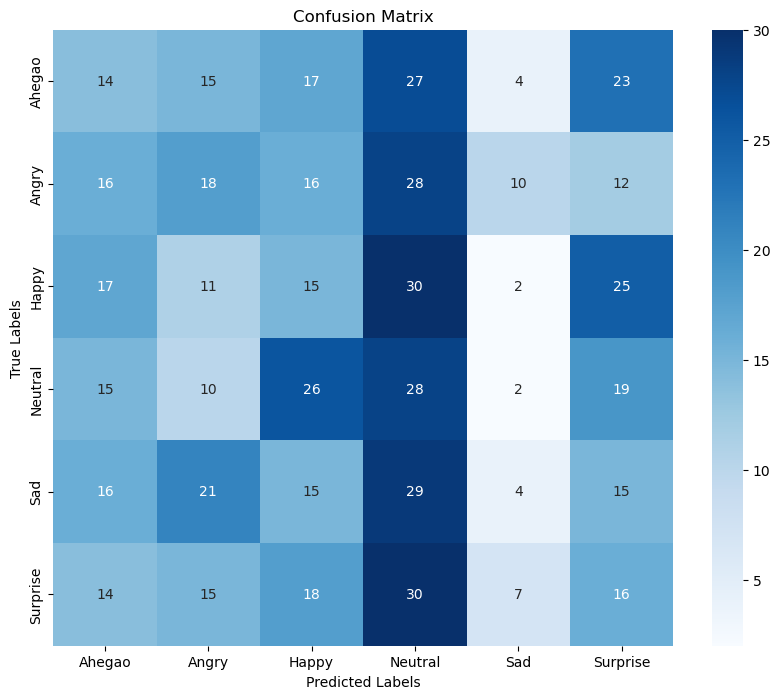

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=expression_labels, yticklabels=expression_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## AUC Plotting

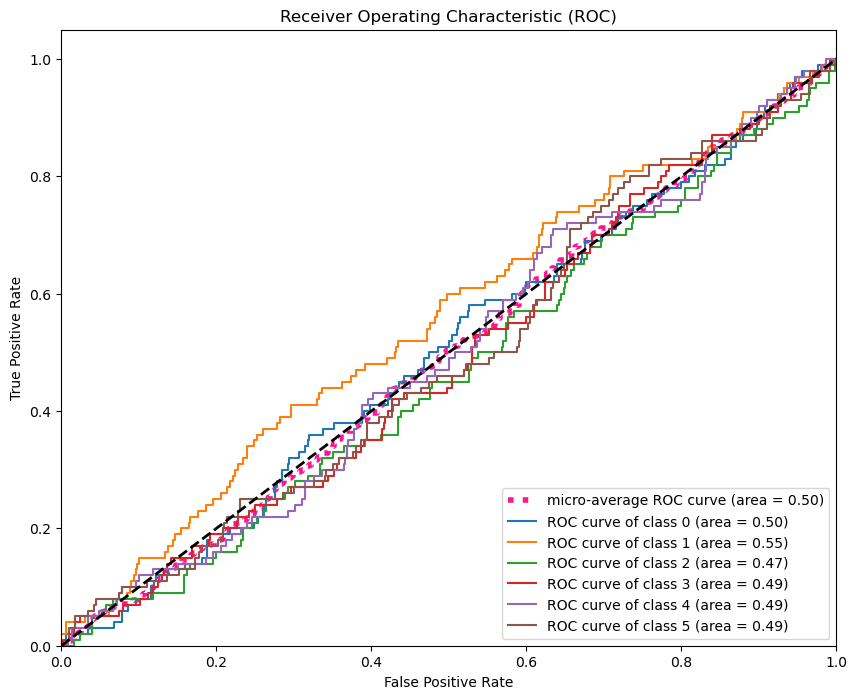

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(num_classes)[y_test][:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(np.eye(num_classes)[y_test].ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Generating Predictions from the model

['Angry', 'Sad', 'Angry', 'Angry', 'Neutral', 'Angry', 'Ahegao', 'Angry', 'Angry', 'Ahegao']


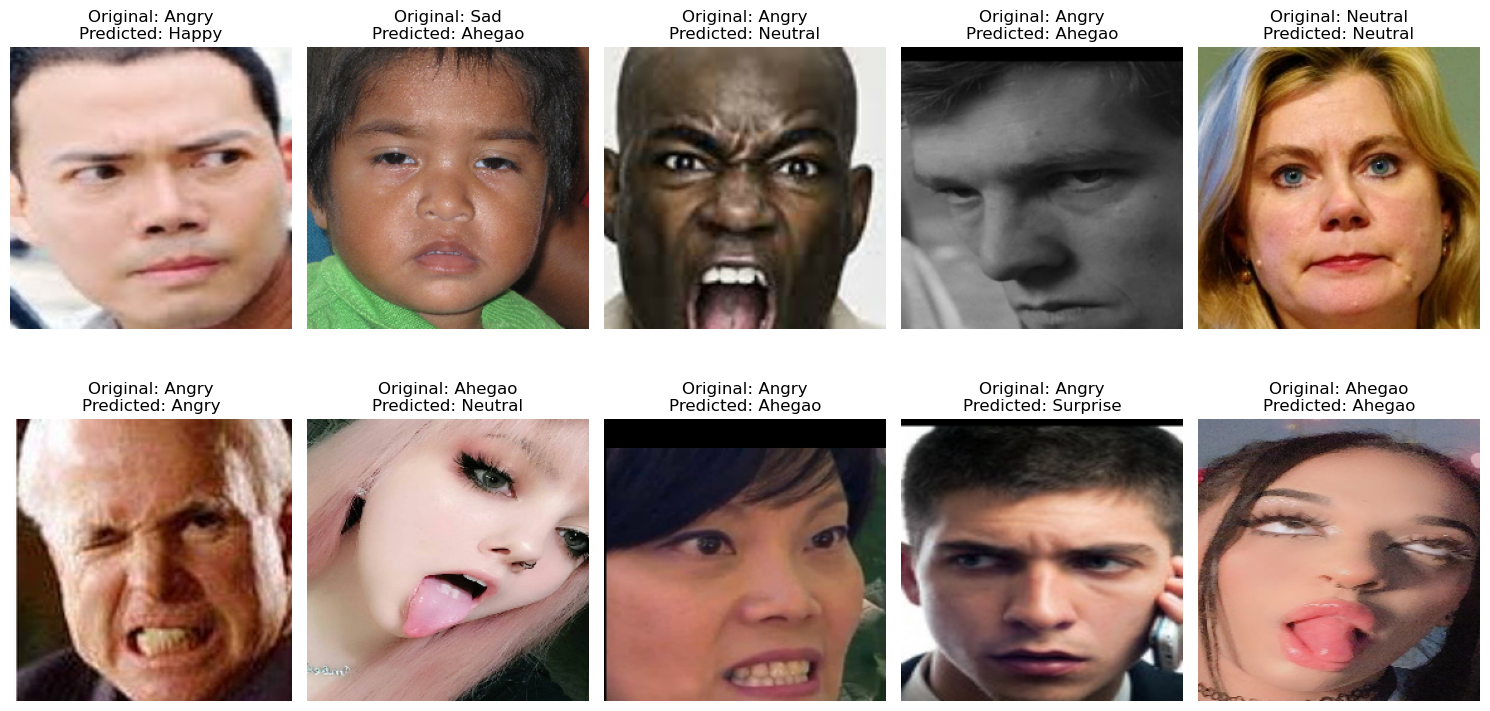

In [ ]:
subset_indices = random.sample(range(len(X_test)), 10)
subset_images = X_test[subset_indices]
subset_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in subset_images]

subset_labels = [expression_labels[label] for label in y_test[subset_indices]]
print(subset_labels)
subset_pred_labels = [expression_labels[label] for label in y_pred_classes[subset_indices]]

num_images_to_display = min(10, len(subset_images))  # Limit the number of images to display
num_cols = math.ceil(len(subset_images) / 2)

fig, axes = plt.subplots(2, num_cols, figsize=(15, 8))

for i in range(len(subset_images)):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(subset_images[i])
    axes[row, col].set_title(f"Original: {subset_labels[i]}\nPredicted: {subset_pred_labels[i]}")
    axes[row, col].axis('off')

for i in range(len(subset_images), 2*num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Implementing Model Interpretability

In [ ]:
def compute_gradients(input_image, model):
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_image)
        top_class_index = tf.argmax(predictions[0])
        top_class_score = predictions[0][top_class_index]
    gradients = tape.gradient(top_class_score, input_tensor)
    return gradients

# Function to generate saliency map for an input image
def generate_saliency_map(input_image, model):
    gradients = compute_gradients(input_image, model)
    if gradients is None:
        return None
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)
    return saliency_map

# Function to plot the original image and its corresponding saliency map
def plot_saliency_map(input_image, saliency_map):
    if saliency_map is None:
        print("Saliency map is None, cannot plot.")
        return
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_image)
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].axis('off')
    axes[1].set_title('Saliency Map')
    plt.show()

In [ ]:
input_image = np.expand_dims(X_train[0], axis=0)
saliency_map = generate_saliency_map(input_image, model)
plot_saliency_map(input_image, saliency_map)

Saliency map is None, cannot plot.
